In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/Colab/IDL_Final_Project/new
# %cd /content/gdrive/My\ Drive/IDL_Final_Project/new

/content/gdrive/.shortcut-targets-by-id/1Sr9hCVVWERdsdT-sePtsjuVIxzvSrDI1/Colab/IDL_Final_Project/new


In [7]:
!pip install noisereduce

  Created wheel for noisereduce: filename=noisereduce-1.1.0-cp36-none-any.whl size=7610 sha256=c3c1a46dd60c5123432a6b07d6fd486a6d56286bff5940bb78b7018d5a8f3455
  Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce


In [10]:
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
# from IPython.display import Audio, display

In [8]:
import noisereduce as nr

/usr/local/lib/python3.6/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Removing silence: https://medium.com/@ngbala6/audio-processing-and-remove-silence-using-python-a7fe1552007a

In [ ]:
# read ECG data from the WAV file
sampleRate, data = wavfile.read('mixer/wav_files/20090713_122937_5.wav')
times = np.arange(len(data))/sampleRate

# apply a 3-pole lowpass filter at 0.1x Nyquist frequency
b, a = scipy.signal.butter(3, 0.1)
filtered = scipy.signal.filtfilt(b, a, data,axis=0)

In [ ]:
# data.shape
times.shape

(4841760,)

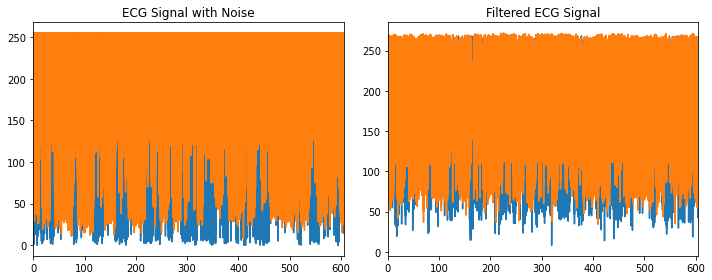

In [ ]:
# plot the original data next to the filtered data

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(times, data)
plt.title("ECG Signal with Noise")
plt.margins(0, .05)

plt.subplot(122)
plt.plot(times, filtered)
plt.title("Filtered ECG Signal")
plt.margins(0, .05)

plt.tight_layout()
plt.show()

# Voice Activity Detector

In [ ]:
!pip install webrtcvad

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp36-cp36m-linux_x86_64.whl size=71350 sha256=49429eea83a5ee022e7e1066600515e17bbfcff15b5a87de6b5bf0f99c3443af
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad


In [ ]:
import collections
import contextlib
import sys
import wave
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

import webrtcvad


# vad = webrtcvad.Vad()  # = webrtcvad.Vad(3) ==> 3 is aggressiveness mode
# vad.set_mode(1)  # Setting aggressiveness mode, which is an integer between 0 and 3

In [ ]:
def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        print("num_channels", num_channels)
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        print("sample_width", sample_width)
        # assert sample_width == 2
        sample_rate = wf.getframerate()
        print("sample_rate", sample_rate)
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.
    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        # wf.setsampwidth(2)
        wf.setsampwidth(1)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.
    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.
    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.
    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.
    Arguments:
    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).
    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])

In [ ]:
def main(wav_file):
    aggressiveness = 3
    audio, sample_rate = read_wave(wav_file)
    vad = webrtcvad.Vad(aggressiveness)
    frames = frame_generator(30, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(sample_rate, 20, 300, vad, frames)
    for i, segment in enumerate(segments):
        path = 'chunk-%002d.wav' % (i,)
        print(' Writing %s' % (path,))
        write_wave(path, segment, sample_rate)

In [ ]:
WAV_FILENAME =  'mixer/1-channel-wav/20090715_161726_18.wav'
main(WAV_FILENAME)

num_channels 1
sample_width 1
sample_rate 8000
0111111111000000000000000000000000000000000111001111100111011100000000000111011111111111+(2.1900000000000004)111111000011100000000000000-(3.449999999999992) Writing chunk-00.wav
0000000000000000000000000000000000000000000000000000011111111111111+(5.009999999999997)111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000-(8.700000000000006) Writing chunk-01.wav
000000000111100000000000000000000000000000000000011111111111110000000000000000000000000000000000000011111100000000000000000000000000000000111111111111000000000000000000000011111111111111+(13.829999999999897)00000000000000-(14.699999999999878) Writing chunk-02.wav
000000011111111111110000000000000000000000000000000000000000000000000011111111111111+(16.76999999999988)11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

## Extracting Channel 1 from audios

In [ ]:
import wave
import numpy as np

def save_wav_channel(fn, wav, channel):
    '''
    Take Wave_read object as an input and save one of its
    channels into a separate .wav file.
    '''
    # Read data
    nch   = wav.getnchannels()
    depth = wav.getsampwidth()
    wav.setpos(0)
    sdata = wav.readframes(wav.getnframes())

    # Extract channel data (24-bit data not supported)
    typ = { 1: np.uint8, 2: np.uint16, 4: np.uint32 }.get(depth)
    if not typ:
        raise ValueError("sample width {} not supported".format(depth))
    if channel >= nch:
        raise ValueError("cannot extract channel {} out of {}".format(channel+1, nch))
    # print ("Extracting channel {} out of {} channels, {}-bit depth".format(channel+1, nch, depth*8))
    data = np.fromstring(sdata, dtype=typ)
    ch_data = data[channel::nch]

    # Save channel to a separate file
    outwav = wave.open(fn, 'w')
    outwav.setparams(wav.getparams())
    outwav.setnchannels(1)
    outwav.writeframes(ch_data.tostring())
    outwav.close()

# WAV_FILENAME =  "mixer/wav_files/20090713_122937_5.wav"
# wav = wave.open(WAV_FILENAME)
# save_wav_channel('ch1.wav', wav, 0)
# save_wav_channel('ch2.wav', wav, 1)

In [ ]:
# 1-channel-wav
import pandas as pd

df = pd.read_csv('mixer/1000_downloaded_mixer6_calls.csv')

In [ ]:
from time import time

count = 0
start = time()
t0 = time()
for row in df.itertuples():
  wav = wave.open('mixer/wav_files/' + row.filename)
  save_wav_channel('mixer/1-channel-wav/' + row.filename, wav, 0)

  if count == 0:
    print("Time taken (1 iteration): {} sec".format(time() - start))
  
  count += 1

print('Total number audios precessed: {}, time taken: {} secs'.format(count, time() - t0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Time taken (1 iteration): 0.6454970836639404 sec
Total number audios precessed: 1000, time taken: 826.8968191146851 secs


In [ ]:
ipd.Audio('ch1.wav')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.Audio('ch2.wav')

Output hidden; open in https://colab.research.google.com to view.

## Sox

In [ ]:
# !apt-get install sox
!pip install sox

In [ ]:
import sox

# sox.file_info.num_samples('ch1.wav')
# sox.file_info.silent('ch1.wav')
# create combiner
cbn = sox.Combiner()
sample_rate = sox.file_info.sample_rate('ch1.wav') 
cbn.convert(samplerate=sample_rate, n_channels=1, bitdepth=16)

This install of SoX cannot process .wav files.


In [ ]:
sox.file_info.info('ch1.wav') #605.22 sec

This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.


{'bitdepth': 8,
 'bitrate': 64000.0,
 'channels': 1,
 'duration': 605.22,
 'encoding': 'Unsigned Integer PCM',
 'num_samples': 4841760,
 'sample_rate': 8000.0,
 'silent': False}

## Using Pydub

In [ ]:
!pip install pydub

In [ ]:
# Import the AudioSegment class for processing audio and the 
# split_on_silence function for separating out silent chunks.
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Define a function to normalize a chunk to a target amplitude.
def match_target_amplitude(aChunk, target_dBFS):
    ''' Normalize given audio chunk '''
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)

# Load your audio.
song = AudioSegment.from_wav("ch1.wav")

# Split track where the silence is 2 seconds or more and get chunks using 
# the imported function.
chunks = split_on_silence (
    # Use the loaded audio.
    song, 
    # Specify that a silent chunk must be at least 2 seconds or 2000 ms long.
    min_silence_len = 500,
    # Consider a chunk silent if it's quieter than -16 dBFS.
    # (You may want to adjust this parameter.)
    silence_thresh = -5
)

# Process each chunk with your parameters
for i, chunk in enumerate(chunks):
    # Create a silence chunk that's 0.5 seconds (or 500 ms) long for padding.
    silence_chunk = AudioSegment.silent(duration=500)

    # Add the padding chunk to beginning and end of the entire chunk.
    # audio_chunk = silence_chunk + chunk + silence_chunk

    # Normalize the entire chunk.
    normalized_chunk = match_target_amplitude(chunk, -20.0)

    # Export the audio chunk with new bitrate.
    print("Exporting chunk{0}.wav.".format(i))
    normalized_chunk.export(
        ".//chunk{0}.wav".format(i),
        bitrate = "192k",
        format = "wav"
    )

Exporting chunk0.wav.
Exporting chunk1.wav.
Exporting chunk2.wav.
Exporting chunk3.wav.
Exporting chunk4.wav.
Exporting chunk5.wav.
Exporting chunk6.wav.
Exporting chunk7.wav.
Exporting chunk8.wav.
Exporting chunk9.wav.
Exporting chunk10.wav.
Exporting chunk11.wav.
Exporting chunk12.wav.
Exporting chunk13.wav.
Exporting chunk14.wav.
Exporting chunk15.wav.
Exporting chunk16.wav.
Exporting chunk17.wav.
Exporting chunk18.wav.
Exporting chunk19.wav.
Exporting chunk20.wav.
Exporting chunk21.wav.
Exporting chunk22.wav.
Exporting chunk23.wav.
Exporting chunk24.wav.
Exporting chunk25.wav.
Exporting chunk26.wav.
Exporting chunk27.wav.
Exporting chunk28.wav.
Exporting chunk29.wav.
Exporting chunk30.wav.
Exporting chunk31.wav.
Exporting chunk32.wav.
Exporting chunk33.wav.
Exporting chunk34.wav.
Exporting chunk35.wav.
Exporting chunk36.wav.
Exporting chunk37.wav.
Exporting chunk38.wav.
Exporting chunk39.wav.
Exporting chunk40.wav.
Exporting chunk41.wav.
Exporting chunk42.wav.
Exporting chunk43.wav

## Using webrtcvad

In [ ]:
ipd.Audio('mixer/wav_files/20090715_161726_18.wav')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
FILENAME = 'mixer/1-channel-wav/20090715_161726_18.wav'
ipd.Audio(FILENAME)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def trim_long_silences(wav):
    """
    Ensures that segments without voice in the waveform remain no longer than a 
    threshold determined by the VAD parameters in params.py.

    :param wav: the raw waveform as a numpy array of floats 
    :return: the same waveform with silences trimmed away (length <= original wav length)
    """
    # Compute the voice detection window size

    vad_window_length = 0.03
    # sampling_rate = wv.getframerate()

    wav, sampling_rate = read_wave(wav)

    # window_duration = 0.03 # duration in seconds
    # samples_per_window = int(window_duration * sample_rate + 0.4)

    samples_per_window = (vad_window_length * sampling_rate) // 1000
    
    # Trim the end of the audio to have a multiple of the window size
    wav = wav[:len(wav) - (len(wav) % samples_per_window)]
    
    # Convert the float waveform to 16-bit mono PCM
    pcm_wave = struct.pack("%dh" % len(wav), *(np.round(wav * int16_max)).astype(np.int16))
    
    # Perform voice activation detection
    voice_flags = []
    vad = webrtcvad.Vad(mode=3)
    for window_start in range(0, len(wav), samples_per_window):
        window_end = window_start + samples_per_window
        voice_flags.append(vad.is_speech(pcm_wave[window_start * 2:window_end * 2],
                                         sample_rate=sampling_rate))
    voice_flags = np.array(voice_flags)
    
    # Smooth the voice detection with a moving average
    def moving_average(array, width):
        array_padded = np.concatenate((np.zeros((width - 1) // 2), array, np.zeros(width // 2)))
        ret = np.cumsum(array_padded, dtype=float)
        ret[width:] = ret[width:] - ret[:-width]
        return ret[width - 1:] / width
    
    audio_mask = moving_average(voice_flags, vad_moving_average_width)
    audio_mask = np.round(audio_mask).astype(np.bool)
    
    # Dilate the voiced regions
    audio_mask = binary_dilation(audio_mask, np.ones(vad_max_silence_length + 1))
    audio_mask = np.repeat(audio_mask, samples_per_window)
    
    return wav[audio_mask == True]

In [ ]:
# wav = wave.open('mixer/1-channel-wav/20090715_161726_18.wav')
# # wav.getframerate()
out = trim_long_silences('mixer/1-channel-wav/20090715_161726_18.wav')

num_channels 1
sample_width 1
sample_rate 8000


ZeroDivisionError: ignored

In [ ]:
sample_rate, samples = wavfile.read(FILENAME)

vad = webrtcvad.Vad()

# set aggressiveness from 0 to 3
vad.set_mode(3)

In [ ]:
import struct
raw_samples = struct.pack("%dh" % len(samples), *samples)

In [ ]:
# run the detector on windows of 30 ms

window_duration = 0.03 # duration in seconds

samples_per_window = int(window_duration * sample_rate + 0.4)

bytes_per_sample = 2

In [ ]:
segments = []

for start in np.arange(0, len(samples), samples_per_window):
    stop = min(start + samples_per_window, len(samples))

    is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample], 
                              sample_rate = sample_rate)

    segments.append(dict(
       start = start,
       stop = stop,
       is_speech = is_speech))

Error: ignored

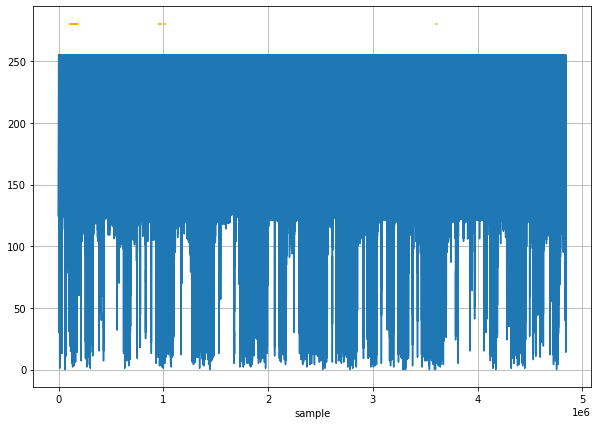

In [ ]:
# plot the range of samples identified as speech in orange

plt.figure(figsize = (10,7))
plt.plot(samples)

ymax = max(samples)


# plot segment identifed as speech
for segment in segments:
    if segment['is_speech']:
        plt.plot([ segment['start'], segment['stop'] - 1], [ymax * 1.1, ymax * 1.1], color = 'orange')

plt.xlabel('sample')
plt.grid()

In [ ]:
# Listen to the speech only segments

speech_samples = np.concatenate([ samples[segment['start']:segment['stop']] for segment in segments if segment['is_speech']])

import IPython.display as ipd
ipd.Audio(speech_samples, rate=sample_rate)